#### Sentiment Analysis Pipeline

source: https://github.com/bertcarremans/TwitterUSAirlineSentiment/blob/master/source/Predicting%20sentiment%20with%20text%20features.ipynb

## Import modules and load data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

from time import time
import re
import string
import os
import emoji
from pprint import pprint
import collections

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report

from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib

import gensim

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
np.random.seed(37)

In [3]:
from sklearn.preprocessing import MinMaxScaler
import pickle

In [4]:
df = pd.read_csv('Tweets.csv')
df = df.reindex(np.random.permutation(df.index))
df = df[['text', 'airline_sentiment']]

In [3]:
df.head(5)

,text,airline_sentiment
1277,@united WHERE IS MY RECEIPT! I upgraded return...,negative
14167,@AmericanAir you should be contacting her for ...,neutral
2875,@united anything yet JJ?,neutral
3865,.@united: Just landed. A day Late Flight with ...,negative
8432,@JetBlue Airways Reveals 'Bluemanity' Livery -...,positive


#### 1) Text variable
To analyze the text variable we create a class **TextCounts**. In this class we compute some basic statistics on the text variable. This class can be used later in a Pipeline, as well.

* **count_words** : number of words in the tweet
* **count_mentions** : referrals to other Twitter accounts, which are preceded by a @
* **count_hashtags** : number of tag words, preceded by a #
* **count_capital_words** : number of uppercase words, could be used to *"shout"* and express (negative) emotions
* **count_excl_quest_marks** : number of question or exclamation marks
* **count_urls** : number of links in the tweet, preceded by http(s)
* **count_emojis** : number of emoji, which might be a good indication of the sentiment

In [5]:
class TextCounts(BaseEstimator, TransformerMixin):
    def count_regex(self, pattern, text):
        return len(re.findall(pattern, text))
    
    def fit(self, X, y = None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    # X here is a pd.Series not a pd.DataFrame
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))
        
        df = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                          })
        return df
        

In [8]:
tc = TextCounts()
df_eda = tc.fit_transform(df.text)
# Add airline_sentiment to df_eda
df_eda['airline_sentiment'] = df.airline_sentiment

In [11]:
df_eda.head(4)

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis,airline_sentiment
1277,21,1,0,5,2,1,0,negative
14167,17,1,0,0,0,0,0,neutral
2875,4,1,0,1,1,0,0,neutral
3865,28,1,0,0,0,0,0,negative


It could be interesting to see how the TextStats variables relate to the class variable. Therefore we write a function **show_dist** that provides descriptive statistics and a plot per target class.

In [26]:
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('airline_sentiment')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='airline_sentiment', hue='airline_sentiment', palette="PuBuGn_d")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()

Descriptive stats for count_mentions
------------------------------------
                    count      mean       std  min  25%  50%  75%  max
airline_sentiment                                                     
negative           9178.0  1.111244  0.365420  1.0  1.0  1.0  1.0  6.0
neutral            3099.0  1.167473  0.480102  1.0  1.0  1.0  1.0  5.0
positive           2363.0  1.138383  0.432462  1.0  1.0  1.0  1.0  6.0


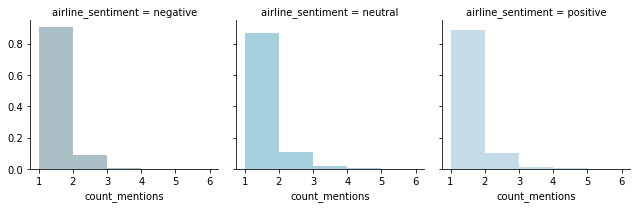

In [27]:
show_dist(df_eda,'count_mentions')

**CONCLUSIONS: **
* **The number of words** used in the tweets is rater low. Maximum number of words is 36 and there are even tweets with only 2 words. So we'll have to be careful during data cleaning not to remove too many words. On the other hand, the text processing will be faster. Negative tweets contain more words than neutral or positive tweets.
* All tweets have at least one **mention**. Probably this is the result of extracting the tweets based on mentions in the Twitter data. There seems to be no difference in number of mentions with regard to the sentiment.
* Most of the tweets do not contain **hash tags**. So probably this variable will not be retained during model training. Again, no difference in number of hash tags with regard to the sentiment.
* Most of the tweets do not contain **capitalized words** and we do not see a difference in distribution between the sentiments.
* The positive tweets seem to be using a bit more **exclamation or question marks**.
* Most tweets do not contain a **URL**. 
* Most tweets do not use **emojis**.

#### Text Cleaning
Before we start using the tweets' text we clean it. We'll do the this in the class CleanText:
- remove the **mentions**, as we want to make the model generalisable to tweets of other airline companies too.
- remove the **hash tag sign** (#) but not the actual tag as this may contain information
- set all words to **lowercase**
- remove all **punctuations**, including the question and exclamation marks
- remove the **urls** as they do not contain useful information and we did not notice a distinction in the number of urls used between the sentiment classes
- make sure the converted **emojis** are kept as one word. 
- remove **digits**
- remove **stopwords**
- apply the **PorterStemmer** to keep the stem of the words

In [9]:
class CleanText(BaseEstimator, TransformerMixin):
    
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)

    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y = None, **fit_params):
        return self
    
    # X is a pd.Series not pd.DataFrame
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions)\
                   .apply(self.remove_urls)\
                   .apply(self.emoji_oneword)\
                   .apply(self.remove_punctuation)\
                   .apply(self.remove_digits).apply(self.to_lower)\
                   .apply(self.remove_stopwords).apply(self.stemming)
        return clean_X
        

In [10]:
ct = CleanText()
sr_clean = ct.fit_transform(df.text)
sr_clean[:5]

10620                                  told work joke fail
13609    aa usair elit member one big disappoint way tr...
2955        bummer might go card instead ty respons though
3585     well incom flight dca take us ewr delay made u...
2087     tri chang flight three time phone got disconne...
Name: text, dtype: object

In [ ]:
mask = sr_clean == ''
print('there are {} records with no words after cleaning'.format(mask.sum()))
sr_clean.loc[mask] = '[no_text]'

In [9]:
df.text.head(5)

10620    @USAirways told to work it out ourselves #joke...
13609    @AmericanAir that all AA is for USAir Elite me...
2955     @united Bummer. Might have to go with @America...
3585     @united well the income flight to dca to take ...
2087     @united we have tried to change our flight THR...
Name: text, dtype: object

**NOTE: **One side-effect of text cleaning is that some rows do not have any words left in their text. For the CountVectorizer and TfIdfVectorizer this does not really pose a problem. However, for the Word2Vec algorithm this causes an error. There are different strategies that you could apply to deal with these missing values.

* Remove the complete row, but in a production environment this is not really desirable.
* Impute the missing value with some placeholder text like *[no_text]*
* Word2Vec: use the average of all vectors

Here we will impute with a placeholder text.

there are 22 records with no words after cleaning


Now that we have the cleaned text of the tweets, we can have a look at what are the most frequent words. Below we'll show the top 20 words. 

**CONCLUSION: **Not surprisingly the most frequent word is *flight*.

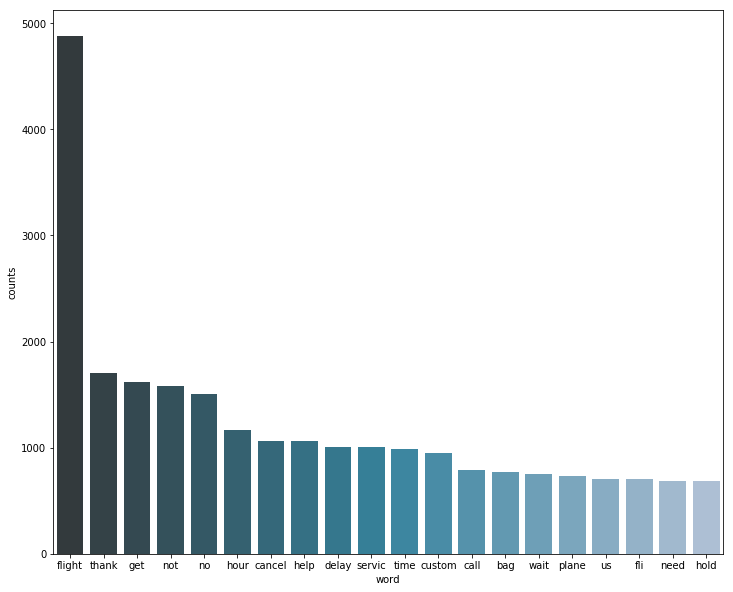

In [71]:
cv = CountVectorizer()
count_sr_clean = cv.fit_transform(sr_clean).toarray()

count_sr_clean = pd.DataFrame({'counts': count_sr_clean.sum(axis = 0)
                               ,'word': cv.get_feature_names()
                              })
top_20 = count_sr_clean.sort_values(by = 'counts', ascending= False ).head(20)
fig, ax = plt.subplots(figsize=(8, 8))
sns.barplot(data = top_20 , x = 'word', y = 'counts', palette= "PuBuGn_d")
plt.show();

## get final dataset

First we combine the TextCounts variables with the CleanText variable.

**NOTE: **Initially, I made the mistake to do execute TextCounts and CleanText in the GridSearchCV below. This took too long as it applies these functions each run of the GridSearch. It suffices to run them only once.

In [12]:
df_model = df_eda
df_model['clean_text'] = sr_clean
df_model.columns.tolist()

['count_words',
 'count_mentions',
 'count_hashtags',
 'count_capital_words',
 'count_excl_quest_marks',
 'count_urls',
 'count_emojis',
 'airline_sentiment',
 'clean_text']

In [74]:
df_model.head(3)

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis,airline_sentiment,clean_text
1277,21,1,0,5,2,1,0,negative,receipt upgrad return leg month late flightr s...
14167,17,1,0,0,0,0,0,neutral,contact refund dm provid phone number
2875,4,1,0,1,1,0,0,neutral,anyth yet jj


So df_model now contains several variables. However, our vectorizers (see below) will only need the *clean_text* variable. The TextCounts variables can be added as such. To specifically select columns, I wrote the class **ColumnExtractor** below. This can be used in the Pipeline afterwards.

## Hyperparameter tuning and cross-validation
As we will see below, the vectorizers and classifiers all have configurable parameters. In order to chose the best parameters, we need to evaluate on a separate validation set that was not used during the training. However, using only one validation set may not produce reliable validation results. Due to chance you might have a good model performance on the validation set. If you would split the data otherwise, you might end up with other results. To get a more accurate estimation, we perform **cross-validation**. 

With cross-validation the data is split into a train and validation set multiple times. The evaluation metric is then averaged over the different folds. Luckily, GridSearchCV applies cross-validation out-of-the-box.

To find the best parameters for both a vectorizer and classifier, we create a **Pipeline**. All this is put into a function for ease of use.

### Evaluation metrics
By default GridSearchCV uses the default scorer to compute the *best_score_*. For both the MultiNomialNb and LogisticRegression this default scoring metric is the accuracy. 

In our function *grid_vect* we additionally generate the *classification_report* on the test data. This provides some interesting metrics **per target class**, which might be more appropriate here. These metrics are the **precision, recal and F1 score.**

* **Precision: ** Of all rows we predicted to be a certain class, how many did we correctly predict?
* **Recall: ** Of all rows of a certain class, how many did we correctly predict?
* **F1 score: ** Harmonic mean of Precision and Recall.

Precision and Recall can be calculated with the elements of the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df_model.drop('airline_sentiment', axis=1), df_model.airline_sentiment, test_size=0.1, random_state=37)

In [16]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols
    
    def fit(self, X, y=None, **fit_params):
        return self
     
    def transform(self, X, **transform_params):
        return X[self.cols]

In [27]:
def grid_vect(clf, parameters_clf, parameters_text=None, vect=None):
    """
    build the pipeline (counts + texts)-> clf
    """
    textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags'
                      ,'count_mentions','count_urls','count_words']
    
    counts_steps = [('counts_col', ColumnExtractor(textcountscols))
                  ,('scaler', MinMaxScaler())]
    counts_pipe = Pipeline(counts_steps)
    
    texts_steps = [('text_col', ColumnExtractor(cols ='clean_text')) #shouldn't use ['clean_text']
                  ,('vect', vect)]
    texts_pipe = Pipeline(texts_steps)
    
    features = FeatureUnion([('counts', counts_pipe),
                            ('texts', texts_pipe)])
    
    pipeline = Pipeline([
    ('features', features),
    ('clf', clf)
     ])
    
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)
        
    parameters.update(parameters_clf)
    
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=3)
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    
    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print('')
    
    print('best CV score %.3f'%(grid_search.best_score_))
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
    
    print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test, y_test))
    print("\n")
    print("Classification Report Test Data")
    print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))
                        
    return grid_search
    


In [15]:
# Parameter grid settings for the vectorizers (Count and TFIDF)
parameters_vect = {
    'features__texts__vect__max_df': (0.25, 0.5, 0.75),
    'features__texts__vect__ngram_range': ((1, 1), (1, 2)),
    'features__texts__vect__min_df': (1,2)
}


# Parameter grid settings for MultinomialNB
parameters_mnb = {
    'clf__alpha': (0.25, 0.5, 0.75)
}


# Parameter grid settings for LogisticRegression
parameters_logreg = {
    'clf__C': (0.25, 0.5, 1.0),
    'clf__penalty': ('l1', 'l2')
}

## Classifiers
Here we will compare the performance of a MultinomailNB and LogisticRegression.

In [23]:
mnb = MultinomialNB()
logreg = LogisticRegression()

## CountVectorizer
To use words in a classifier, we need to convert the words to numbers. This can be done with a CountVectorizer. Sklearn's **CountVectorizer** takes all words in all tweets, assigns an ID and counts the frequency of the word per tweet. This *bag of words* can then be used as input for a classifier. It is what is called a **sparse** data set, meaning that each record will have many zeroes for the words not occurring in the tweet.

In [105]:
countvect = CountVectorizer()
# MultinomialNB
best_mnb_countvect = grid_vect(mnb, parameters_mnb, parameters_text=parameters_vect, vect=countvect)
joblib.dump(best_mnb_countvect, 'best_mnb_countvect.pkl')

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__texts__vect__max_df': (0.25, 0.5, 0.75),
 'features__texts__vect__min_df': (1, 2),
 'features__texts__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:   21.9s finished
/Users/xduan/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


done in 22.472s

best CV score 0.770
	clf__alpha: 0.25
	features__texts__vect__max_df: 0.25
	features__texts__vect__min_df: 1
	features__texts__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.785


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.80      0.95      0.87       925
     neutral       0.72      0.42      0.53       331
    positive       0.78      0.64      0.71       208

   micro avg       0.78      0.78      0.78      1464
   macro avg       0.77      0.67      0.70      1464
weighted avg       0.78      0.78      0.77      1464



['best_mnb_countvect.pkl']

In [18]:
countvect = CountVectorizer()
# LogisticRegression
best_logreg_countvect = grid_vect(logreg, parameters_logreg, parameters_text=parameters_vect, vect=countvect)
joblib.dump(best_logreg_countvect, 'best_logreg_countvect.pkl')

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0),
 'clf__penalty': ('l1', 'l2'),
 'features__texts__vect__max_df': (0.25, 0.5, 0.75),
 'features__texts__vect__min_df': (1, 2),
 'features__texts__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:   57.1s finished
/Users/xduan/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


done in 58.212s

best CV score 0.792
	clf__C: 1.0
	clf__penalty: 'l2'
	features__texts__vect__max_df: 0.5
	features__texts__vect__min_df: 1
	features__texts__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.811


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.83      0.93      0.88       911
     neutral       0.74      0.54      0.62       320
    positive       0.79      0.73      0.76       233

   micro avg       0.81      0.81      0.81      1464
   macro avg       0.79      0.73      0.75      1464
weighted avg       0.80      0.81      0.80      1464



['best_logreg_countvect.pkl']

In [20]:
with open('best_logreg_countvect_pickle.pkl', 'wb') as p:
    pickle.dump(best_logreg_countvect, p)

## TF-IDF
One issue with CountVectorizer is that there might be words that occur frequently in observations of the target classes. These words do not have discriminatory information and can be removed. [TF-IDF (term frequency - inverse document frequency)](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) can be used to downweight these frequent words.

In [107]:
tfidfvect = TfidfVectorizer()

In [109]:
# MultinomialNB
best_mnb_tfidf = grid_vect(mnb, parameters_mnb, parameters_text=parameters_vect, vect=tfidfvect)
joblib.dump(best_mnb_tfidf, 'best_mnb_tfidf.pkl')

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__texts__vect__max_df': (0.25, 0.5, 0.75),
 'features__texts__vect__min_df': (1, 2),
 'features__texts__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:   23.0s finished
/Users/xduan/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


done in 23.514s

best CV score 0.752
	clf__alpha: 0.25
	features__texts__vect__max_df: 0.25
	features__texts__vect__min_df: 2
	features__texts__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.763


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.75      0.97      0.85       925
     neutral       0.75      0.35      0.48       331
    positive       0.85      0.51      0.64       208

   micro avg       0.76      0.76      0.76      1464
   macro avg       0.79      0.61      0.65      1464
weighted avg       0.77      0.76      0.73      1464



['best_mnb_tfidf.pkl']

In [110]:
# LogisticRegression
best_logreg_tfidf = grid_vect(logreg, parameters_logreg, parameters_text=parameters_vect, vect=tfidfvect)
joblib.dump(best_logreg_tfidf, 'best_logreg_tfidf.pkl')

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0),
 'clf__penalty': ('l1', 'l2'),
 'features__texts__vect__max_df': (0.25, 0.5, 0.75),
 'features__texts__vect__min_df': (1, 2),
 'features__texts__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:   52.0s finished
/Users/xduan/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


done in 52.291s

best CV score 0.786
	clf__C: 1.0
	clf__penalty: 'l2'
	features__texts__vect__max_df: 0.25
	features__texts__vect__min_df: 2
	features__texts__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.808


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.83      0.95      0.88       925
     neutral       0.75      0.56      0.64       331
    positive       0.76      0.58      0.66       208

   micro avg       0.81      0.81      0.81      1464
   macro avg       0.78      0.70      0.73      1464
weighted avg       0.80      0.81      0.80      1464



['best_logreg_tfidf.pkl']

## Conclusion
* Both classifiers achieve the best results when using the features of the CountVectorizer
* Overall, Logistic Regression outperforms the Multinomial Naive Bayes classifier
* The best performance on the test set comes from the LogisticRegression with features from CountVectorizer. 

Best parameters:
* C value of 1
* L2 regularization
* max_df: 0.5 or maximum document frequency of 50%.
* min_df: 1 or the words need to appear in at least 2 tweets
* ngram_range: (1, 2), both single words as bi-grams are used

Evaluation metrics:
* A **test accuracy** of 81,3%, which is better than what we would achieve by setting the prediction for all observations to the majority class (*negative* which would give 63% accuracy).
* The **Precision** is rather high for all three classes. For instance, of all cases that we predict as negative, 80% is indeed negative.
* The **Recall** for the neutral class is low. Of all neutral cases in our test data, we only predict 48% as being neutral.

In [54]:
textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags'
                  ,'count_mentions','count_urls','count_words']

counts_steps = [('counts_col', ColumnExtractor(textcountscols))
              ,('scaler', MinMaxScaler())]
counts_pipe = Pipeline(counts_steps)

texts_steps = [('text_col', ColumnExtractor(cols ='clean_text')) #shouldn't use ['clean_text']
              ,('vect', CountVectorizer(max_df=0.5, min_df=2, ngram_range=(1,2)))]
texts_pipe = Pipeline(texts_steps)

features = FeatureUnion([('counts', counts_pipe),
                        ('texts', texts_pipe)])

pipeline = Pipeline([
('features', features),
('clf', LogisticRegression(C=0.5, penalty='l2'))
 ])

best_model = pipeline.fit(df_model.drop('airline_sentiment', axis=1), df_model.airline_sentiment)

/Users/xduan/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [51]:
new_positive_tweets = pd.Series(["Thank you @VirginAmerica for you amazing customer support team on Tuesday 11/28 at @EWRairport and returning my lost bag in less than 24h! #efficiencyiskey #virginamerica"
                      ,"Love flying with you guys ask these years.  Sad that this will be the last trip 😂   @VirginAmerica  #LuxuryTravel"
                      ,"Wow @VirginAmerica main cabin select is the way to fly!! This plane is nice and clean & I have tons of legroom! Wahoo! NYC bound! ✈️"])

df_counts_pos = tc.transform(new_positive_tweets)
df_clean_pos = ct.transform(new_positive_tweets)
df_model_pos = df_counts_pos
df_model_pos['clean_text'] = df_clean_pos



In [52]:
best_model.predict(df_model_pos).tolist()

['positive', 'positive', 'negative']

In [55]:
# pickle the model
pipe = best_model

dump_path = 'best_pickle.pkl'

with open(dump_path, 'wb') as p:
    pickle.dump(pipe, p)


In [56]:
# load the model from disk
dump_path = 'best_pickle.pkl'
# loaded_pipeline = pickle.load(open)
with open(dump_path, 'rb') as p:
    pickle_pipeline = pickle.load(p)


In [57]:
pickle_pipeline.predict(df_model_pos).tolist()

['positive', 'positive', 'negative']

### load previous trained model in GridSearch and it worked

In [25]:
# load the model from disk
dump_path = 'best_logreg_countvect_pickle.pkl'
# loaded_pipeline = pickle.load(open)
with open(dump_path, 'rb') as p:
    pickle_pipeline = pickle.load(p)


In [23]:
model = joblib.load('best_logreg_countvect.pkl')

In [26]:
new_positive_tweets = pd.Series(["Thank you @VirginAmerica for you amazing customer support team on Tuesday 11/28 at @EWRairport and returning my lost bag in less than 24h! #efficiencyiskey #virginamerica"
                      ,"Love flying with you guys ask these years.  Sad that this will be the last trip 😂   @VirginAmerica  #LuxuryTravel"
                      ,"Wow @VirginAmerica main cabin select is the way to fly!! This plane is nice and clean & I have tons of legroom! Wahoo! NYC bound! ✈️"])

df_counts_pos = tc.transform(new_positive_tweets)
df_clean_pos = ct.transform(new_positive_tweets)
df_model_pos = df_counts_pos
df_model_pos['clean_text'] = df_clean_pos



In [27]:
model.predict(df_model_pos).tolist()

['positive', 'positive', 'negative']

In [28]:
pickle_pipeline.predict(df_model_pos).tolist()

['positive', 'positive', 'negative']

In [29]:
new_negative_tweets = pd.Series(["@VirginAmerica shocked my initially with the service, but then went on to shock me further with no response to what my complaint was. #unacceptable @Delta @richardbranson"
                      ,"@VirginAmerica this morning I was forced to repack a suitcase w a medical device because it was barely overweight - wasn't even given an option to pay extra. My spouses suitcase then burst at the seam with the added device and had to be taped shut. Awful experience so far!"
                      ,"Board airplane home. Computer issue. Get off plane, traverse airport to gate on opp side. Get on new plane hour later. Plane too heavy. 8 volunteers get off plane. Ohhh the adventure of travel ✈️ @VirginAmerica"])

df_counts_neg = tc.transform(new_negative_tweets)
df_clean_neg = ct.transform(new_negative_tweets)
df_model_neg = df_counts_neg
df_model_neg['clean_text'] = df_clean_neg

In [30]:
model.predict(df_model_neg).tolist()

['negative', 'negative', 'negative']

In [31]:
pickle_pipeline.predict(df_model_neg).tolist()

['negative', 'negative', 'negative']

In [ ]:
https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/metrics/scorer.py
Try scoring='neg_log_loss'
neg_log_loss_scorer = make_scorer(log_loss, greater_is_better=False,
                                  needs_proba=True)

In [ ]:
log_loss:
https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a